<a href="https://colab.research.google.com/github/faheemdehalvi/Automated-Emergency-Response-System/blob/main/sign_language_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import Data

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! kaggle datasets download -d datamunge/sign-language-mnist

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 88% 55.0M/62.6M [00:00<00:00, 79.1MB/s]
100% 62.6M/62.6M [00:00<00:00, 94.4MB/s]


In [4]:
! unzip /content/sign-language-mnist.zip

Archive:  /content/sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [5]:
train = pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')

In [6]:
train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
X = train.drop(['label'], axis = 1)
y = train['label']

In [8]:
X.shape, y.shape

((27455, 784), (27455,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Hyperparameters

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 28
NUM_CLASS = y.nunique() + 1

# Preprocessing and Data Loader

In [11]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
    # transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop and resize the image to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
])

# Define the fixed transformations
fixed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the overall transformation pipeline
transform = transforms.Compose([
    transforms.RandomApply([random_transforms], p=0.5),  # Apply random transformations with a probability of 0.5
    fixed_transforms
])

In [12]:
class SignDataSet(Dataset):
  def __init__(
      self,
      image_df,
      label_df,
      transform,
      split = None,
  ):
    self.image_df = image_df
    self.label_df = torch.nn.functional.one_hot(torch.tensor(np.array(label_df))).float()
    self.split = split
    self.transform = transform

  def __len__(self):
    return len(self.label_df)

  def __getitem__(self, index):
    image = self.image_df.iloc[index]
    image = np.reshape(np.array(image), (28,28))

    image = Image.fromarray(image.astype(np.uint8))

    label = self.label_df[index]
    # label = torch.nn.functional.one_hot(torch.tensor(label))

    if self.split == 'train':
      image = self.transform(image)
    return image, label





In [13]:

train_data = SignDataSet(X_train, y_train, transform, 'train')
test_data = SignDataSet(X_val, y_val, transform)

In [14]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, drop_last = True)

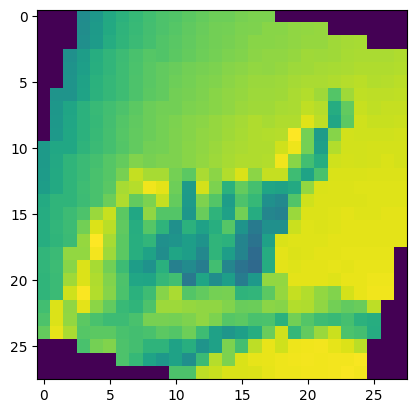

In [15]:
for i, j in train_data:
  temp_img = i

  plt.imshow(temp_img.permute(1,2,0))
  break

# Model Building

In [16]:
class SignLabelModel(nn.Module):
    def __init__(self, num_classes):
        super(SignLabelModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
  # Number of classes
model = SignLabelModel(NUM_CLASS).to(device)

In [17]:
num_epochs = 20
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 3.0537
Epoch [1/20], Loss: 2.9434
Epoch [1/20], Loss: 2.6157
Epoch [1/20], Loss: 1.8103
Epoch [1/20], Loss: 1.5761
Epoch [1/20], Loss: 1.4906


  5%|▌         | 1/20 [00:22<07:03, 22.29s/it]

Epoch [2/20], Loss: 1.2230
Epoch [2/20], Loss: 1.1225
Epoch [2/20], Loss: 1.5457
Epoch [2/20], Loss: 0.8813
Epoch [2/20], Loss: 1.2012
Epoch [2/20], Loss: 0.9805


 10%|█         | 2/20 [00:34<04:50, 16.14s/it]

Epoch [3/20], Loss: 0.7374
Epoch [3/20], Loss: 0.7758
Epoch [3/20], Loss: 1.1635
Epoch [3/20], Loss: 0.5660
Epoch [3/20], Loss: 0.7969
Epoch [3/20], Loss: 0.7713


 15%|█▌        | 3/20 [00:46<04:01, 14.21s/it]

Epoch [4/20], Loss: 0.7363
Epoch [4/20], Loss: 0.7408
Epoch [4/20], Loss: 0.9905
Epoch [4/20], Loss: 0.3721
Epoch [4/20], Loss: 0.9255
Epoch [4/20], Loss: 0.5432


 20%|██        | 4/20 [00:57<03:30, 13.18s/it]

Epoch [5/20], Loss: 0.4025
Epoch [5/20], Loss: 0.5494
Epoch [5/20], Loss: 0.7207
Epoch [5/20], Loss: 0.3640
Epoch [5/20], Loss: 0.5789
Epoch [5/20], Loss: 0.3516


 25%|██▌       | 5/20 [01:09<03:09, 12.64s/it]

Epoch [6/20], Loss: 0.5056
Epoch [6/20], Loss: 0.3809
Epoch [6/20], Loss: 0.7279
Epoch [6/20], Loss: 0.3317
Epoch [6/20], Loss: 0.4248
Epoch [6/20], Loss: 0.4021


 30%|███       | 6/20 [01:21<02:52, 12.32s/it]

Epoch [7/20], Loss: 0.2486
Epoch [7/20], Loss: 0.4036
Epoch [7/20], Loss: 0.5844
Epoch [7/20], Loss: 0.2707
Epoch [7/20], Loss: 0.2674
Epoch [7/20], Loss: 0.4177


 35%|███▌      | 7/20 [01:32<02:34, 11.92s/it]

Epoch [8/20], Loss: 0.2781
Epoch [8/20], Loss: 0.3560
Epoch [8/20], Loss: 0.3480
Epoch [8/20], Loss: 0.1825
Epoch [8/20], Loss: 0.4209
Epoch [8/20], Loss: 0.1824


 40%|████      | 8/20 [01:43<02:20, 11.74s/it]

Epoch [9/20], Loss: 0.2871
Epoch [9/20], Loss: 0.2548
Epoch [9/20], Loss: 0.3983
Epoch [9/20], Loss: 0.2094
Epoch [9/20], Loss: 0.2264
Epoch [9/20], Loss: 0.2921


 45%|████▌     | 9/20 [01:56<02:12, 12.03s/it]

Epoch [10/20], Loss: 0.2192
Epoch [10/20], Loss: 0.2091
Epoch [10/20], Loss: 0.3960
Epoch [10/20], Loss: 0.1688
Epoch [10/20], Loss: 0.0969
Epoch [10/20], Loss: 0.1573


 50%|█████     | 10/20 [02:07<01:59, 11.91s/it]

Epoch [11/20], Loss: 0.1642
Epoch [11/20], Loss: 0.3245
Epoch [11/20], Loss: 0.4050
Epoch [11/20], Loss: 0.1740
Epoch [11/20], Loss: 0.1714
Epoch [11/20], Loss: 0.1291


 55%|█████▌    | 11/20 [02:19<01:46, 11.87s/it]

Epoch [12/20], Loss: 0.1995
Epoch [12/20], Loss: 0.0844
Epoch [12/20], Loss: 0.2117
Epoch [12/20], Loss: 0.1679
Epoch [12/20], Loss: 0.2663
Epoch [12/20], Loss: 0.1595


 60%|██████    | 12/20 [02:31<01:34, 11.86s/it]

Epoch [13/20], Loss: 0.2230
Epoch [13/20], Loss: 0.1576
Epoch [13/20], Loss: 0.2167
Epoch [13/20], Loss: 0.0890
Epoch [13/20], Loss: 0.2054
Epoch [13/20], Loss: 0.1398


 65%|██████▌   | 13/20 [02:42<01:21, 11.68s/it]

Epoch [14/20], Loss: 0.1166
Epoch [14/20], Loss: 0.1149
Epoch [14/20], Loss: 0.2441
Epoch [14/20], Loss: 0.0782
Epoch [14/20], Loss: 0.0496
Epoch [14/20], Loss: 0.0377


 70%|███████   | 14/20 [02:53<01:09, 11.56s/it]

Epoch [15/20], Loss: 0.1456
Epoch [15/20], Loss: 0.1733
Epoch [15/20], Loss: 0.0787
Epoch [15/20], Loss: 0.1947
Epoch [15/20], Loss: 0.0448
Epoch [15/20], Loss: 0.1535


 75%|███████▌  | 15/20 [03:05<00:58, 11.63s/it]

Epoch [16/20], Loss: 0.0863
Epoch [16/20], Loss: 0.0934
Epoch [16/20], Loss: 0.1062
Epoch [16/20], Loss: 0.2144
Epoch [16/20], Loss: 0.0843
Epoch [16/20], Loss: 0.0351


 80%|████████  | 16/20 [03:17<00:46, 11.69s/it]

Epoch [17/20], Loss: 0.0833
Epoch [17/20], Loss: 0.1096
Epoch [17/20], Loss: 0.1544
Epoch [17/20], Loss: 0.0465
Epoch [17/20], Loss: 0.0967
Epoch [17/20], Loss: 0.2252


 85%|████████▌ | 17/20 [03:29<00:35, 11.69s/it]

Epoch [18/20], Loss: 0.0872
Epoch [18/20], Loss: 0.0363
Epoch [18/20], Loss: 0.1541
Epoch [18/20], Loss: 0.0321
Epoch [18/20], Loss: 0.0606
Epoch [18/20], Loss: 0.1760


 90%|█████████ | 18/20 [03:40<00:23, 11.63s/it]

Epoch [19/20], Loss: 0.1003
Epoch [19/20], Loss: 0.2489
Epoch [19/20], Loss: 0.1647
Epoch [19/20], Loss: 0.0792
Epoch [19/20], Loss: 0.0212
Epoch [19/20], Loss: 0.0464


 95%|█████████▌| 19/20 [03:51<00:11, 11.43s/it]

Epoch [20/20], Loss: 0.0499
Epoch [20/20], Loss: 0.0404
Epoch [20/20], Loss: 0.3407
Epoch [20/20], Loss: 0.0414
Epoch [20/20], Loss: 0.2272
Epoch [20/20], Loss: 0.3403


100%|██████████| 20/20 [04:03<00:00, 12.18s/it]

Training finished.
